## DENOISING AUTO ENCODER

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("PACKAGES LOADED")

PACKAGES LOADED


## MNIST

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz


## DEFINE NETWORK

In [5]:
# Network Parameters
n_input    = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 256 # 2nd layer num features
n_output   = 784 # 
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_output])
dropout_keep_prob = tf.placeholder("float")
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_output]))
}
# Create model
def denoising_autoencoder(_X, _weights, _biases, _keep_prob):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_1out = tf.nn.dropout(layer_1, _keep_prob) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1out, _weights['h2']), _biases['b2'])) 
    layer_2out = tf.nn.dropout(layer_2, _keep_prob) 
    return tf.nn.sigmoid(tf.matmul(layer_2out, _weights['out']) + _biases['out'])
print ("NETWORK READY")

NETWORK READY


## DEFINE FUNCTIONS

In [13]:
# MODEL
out = denoising_autoencoder(x, weights, biases, dropout_keep_prob)
# DEFINE LOSS AND OPTIMIZER
# cost = tf.reduce_mean(tf.pow(out-y, 2))
cost = tf.reduce_mean(tf.abs(out-y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost) 
# INITIALIZE
init = tf.global_variables_initializer()
# SAVER
savedir = "data/nets/"
saver = tf.train.Saver(max_to_keep=3) 
print ("FUNCTIONS READY")

FUNCTIONS READY


## RUN

In [14]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=True))
sess.run(init)

START OPTIMIZATION
Epoch: 000/030 cost: 0.131215012


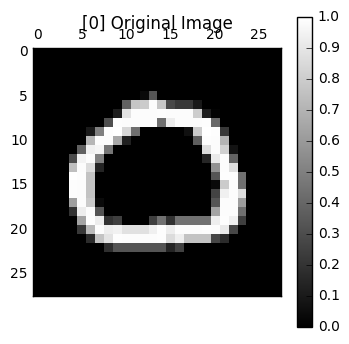

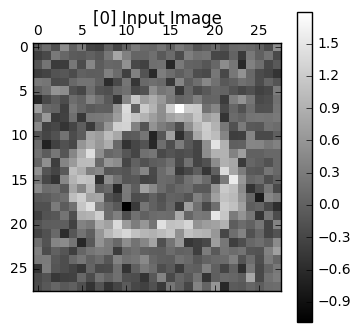

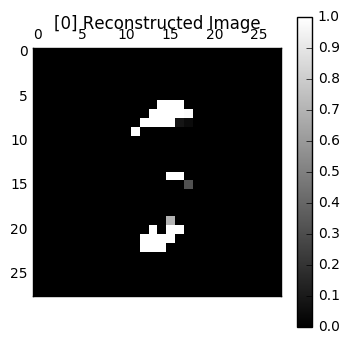

Epoch: 005/030 cost: 0.079596226
Epoch: 010/030 cost: 0.065100854


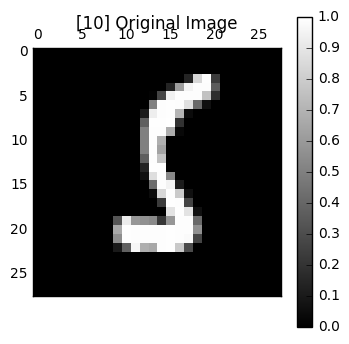

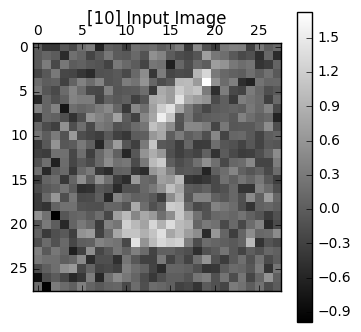

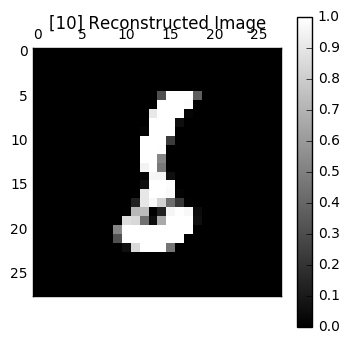

Epoch: 015/030 cost: 0.059647837
Epoch: 020/030 cost: 0.056655275


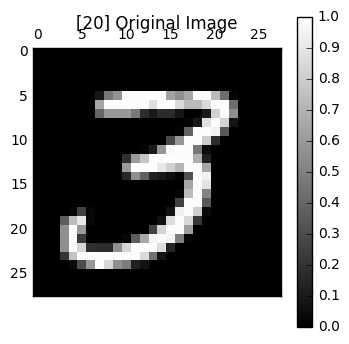

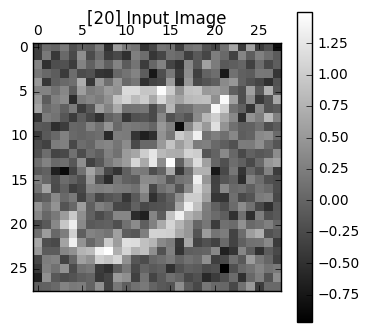

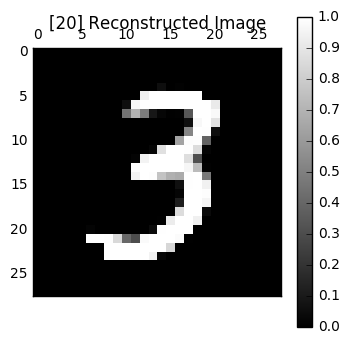

Epoch: 025/030 cost: 0.054393916


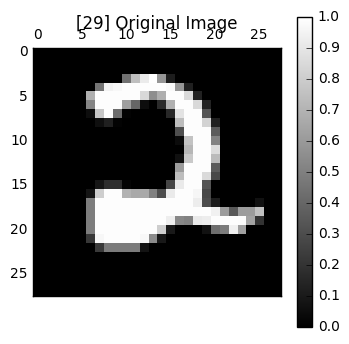

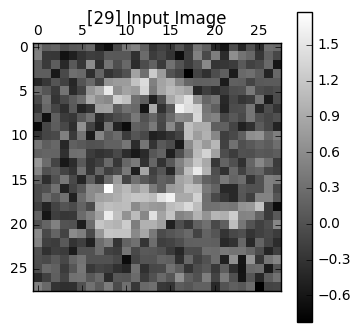

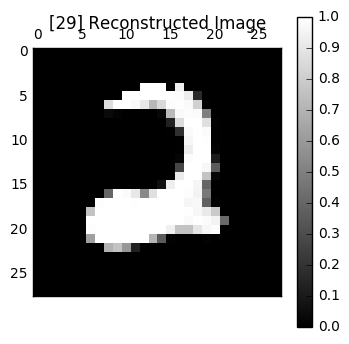

Optimization Finished!


In [15]:
training_epochs = 30
batch_size      = 100
display_step    = 5
plot_step       = 10
if do_train:
    print ("START OPTIMIZATION")
    for epoch in range(training_epochs):
        avg_cost = 0.
        num_batch = int(mnist.train.num_examples/batch_size)
        for i in range(num_batch): 
            randidx = np.random.randint(trainimg.shape[0], size=batch_size)
            batch_xs = trainimg[randidx, :]
            batch_xs_noisy = batch_xs + 0.3*np.random.randn(batch_xs.shape[0], 784)
            feed1 = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 0.5}
            sess.run(optimizer, feed_dict=feed1)
            feed2 = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 1}
            avg_cost += sess.run(cost, feed_dict=feed2)/num_batch

        # DISPLAY
        if epoch % display_step == 0:
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        if epoch % plot_step == 0 or epoch == training_epochs-1:
            # TEST
            randidx  = np.random.randint(testimg.shape[0], size=1)
            testvec  = testimg[randidx, :]
            noisyvec = testvec + 0.3*np.random.randn(1, 784)
            outvec   = sess.run(out, feed_dict={x: testvec, dropout_keep_prob: 1.})
            outimg   = np.reshape(outvec, (28, 28))

            # PLOT 
            plt.matshow(np.reshape(testvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Original Image")
            plt.colorbar()
            plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Input Image")
            plt.colorbar()
            plt.matshow(outimg, cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Reconstructed Image")
            plt.colorbar()
            plt.show()

            # SAVE
            saver.save(sess, savedir + 'dae_dr.ckpt', global_step=epoch)
            
    print ("Optimization Finished!")
else:
    print ("RESTORE")
    saver.restore(sess, "nets/dae_dr.ckpt-" + str(training_epochs-1))

## TEST

label is 2
Salt and Pepper Noise


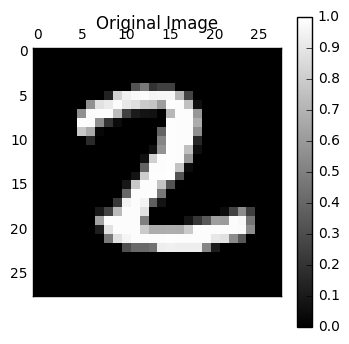

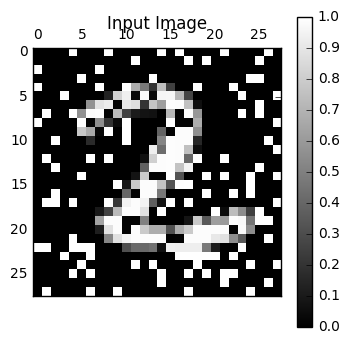

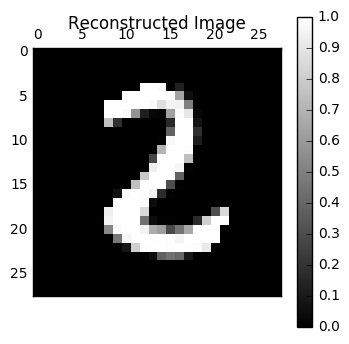

In [16]:
randidx   = np.random.randint(testimg.shape[0], size=1)
orgvec    = testimg[randidx, :]
testvec   = testimg[randidx, :]
label     = np.argmax(testlabel[randidx, :], 1)

print ("label is %d" % (label)) 
# Noise type
ntype = 2 # 1: Gaussian Noise, 2: Salt and Pepper Noise
if ntype is 1:
    print ("Gaussian Noise")
    noisyvec = testvec + 0.1*np.random.randn(1, 784)
else:    
    print ("Salt and Pepper Noise")
    noisyvec = testvec
    rate     = 0.20
    noiseidx = np.random.randint(testimg.shape[1], size=int(testimg.shape[1]*rate))
    noisyvec[0, noiseidx] = 1-noisyvec[0, noiseidx]

outvec   = sess.run(out, feed_dict={x: noisyvec, dropout_keep_prob: 1})
outimg   = np.reshape(outvec, (28, 28))

# Plot 
plt.matshow(np.reshape(orgvec, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("Original Image")
plt.colorbar()

plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("Input Image")
plt.colorbar()

plt.matshow(outimg, cmap=plt.get_cmap('gray'))
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

## VISUALIZE FILTER

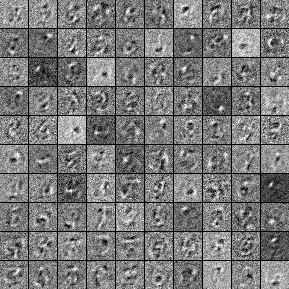

In [11]:
# Visualize Filter 
from PIL import Image

def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar

def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2
    out_shape = [(ishp + tsp) * tshp - tsp for ishp, tshp, tsp
                      in zip(img_shape, tile_shape, tile_spacing)]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype='uint8')
        else:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype=X.dtype)

        #colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                out_array[:, :, i] = np.zeros(out_shape,
                      dtype='uint8' if output_pixel_vals else out_array.dtype
                      ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(X[i], img_shape, tile_shape, tile_spacing, scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        out_array = np.zeros(out_shape, dtype='uint8' if output_pixel_vals else X.dtype)


        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(X[tile_row * tile_shape[1] + tile_col].reshape(img_shape))
                    else:
                        this_img = X[tile_row * tile_shape[1] + tile_col].reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    out_array[
                        tile_row * (H+Hs): tile_row * (H + Hs) + H,
                        tile_col * (W+Ws): tile_col * (W + Ws) + W
                        ] \
                        = this_img * (255 if output_pixel_vals else 1)
        return out_array

# Visualize filter
w1 = sess.run(weights["h1"])

image = Image.fromarray(tile_raster_images(
        X = w1.T,
        img_shape=(28, 28), tile_shape=(10, 10),
        tile_spacing=(1, 1)))
image